# Решение уравнения Пуассона методом конечных разностей (Метод Зейделя)

## Постановка задачи

Мы решаем двумерное уравнение Пуассона на квадратной области $\Omega = [0, l] \times [0, l]$:

$$
\Delta u(x, y) = f(x, y), \quad (x, y) \in \Omega
$$

с граничными условиями Дирихле:

$$
u(x, y) = \phi(x, y), \quad (x, y) \in \partial \Omega
$$

## Метод решения

$$
u_{i,j} = \frac{1}{4} (u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} + h^2 f_{i,j})
$$

Выражение получено из выражение для нашего уравнения

$$
\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h_x^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h_y^2} = f_{i,j}
$$

Систему решаем **методом Зейделя**, используя обновленные значения на текущей итерации.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time 

def solve_poisson_gauss_seidel(l, N, f, phi1, phi2, phi3, phi4, tol=1e-6, max_iter=20000, verbose=True):
    hx = l / (N - 1)
    hy = l / (N - 1)
    if not np.isclose(hx, hy):
        print("Предупреждение: Шаги hx и hy не равны. Формула предполагает hx=hy.")
    h_sq = hx**2

    u = np.zeros((N, N))
    x = np.linspace(0, l, N)
    y = np.linspace(0, l, N)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Граничные условия
    u[:, 0] = phi1(x)
    u[:, -1] = phi2(x)
    u[0, :] = phi3(y)
    u[-1, :] = phi4(y)

    # Согласование углов
    u[0, 0] = 0.5 * (phi1(x[0]) + phi3(y[0]))
    u[-1, 0] = 0.5 * (phi1(x[-1]) + phi4(y[0]))
    u[0, -1] = 0.5 * (phi2(x[0]) + phi3(y[-1]))
    u[-1, -1] = 0.5 * (phi2(x[-1]) + phi4(y[-1]))

    F = f(X, Y)
    iterations = 0
    start_time = time.time()

    for k in range(max_iter):
        u_old = np.copy(u)

        # Итерация метода Зейделя
        for i in range(1, N-1):
            for j in range(1, N-1):
                u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + \
                                  u[i, j+1] + u[i, j-1] + h_sq * F[i, j])

        norm_diff = np.linalg.norm(u - u_old, ord=np.inf)
        if norm_diff < tol:
            iterations = k + 1
            if verbose:
                print(f"Метод Зейделя сошелся за {iterations} итераций.")
            break
    else:
        iterations = max_iter
        if verbose:
             print(f"Метод Зейделя: Достигнуто максимальное количество итераций ({max_iter}). Норма разности: {norm_diff:.2e}")

    end_time = time.time()
    if verbose:
        print(f"Время расчета: {end_time - start_time:.3f} секунд")

    return X, Y, u, F, iterations

## Пример: Тестовая задача с известным решением

Выбираем $u_{exact}(x, y) = \sin(2 \pi x) \cos(\pi y)$.
Тогда $f(x, y) = -\Delta u_{exact} = 5\pi^2 \sin(2\pi x) \cos(\pi y)$.
Граничные условия также вычисляются из $u_{exact}$.

Метод Зейделя сошелся за 1279 итераций.
Время расчета: 1.926 секунд
Параметры сетки: N = 51, h = 0.0200
Количество итераций (Зейдель): 1279
Максимальная абсолютная ошибка: 5.955e-04


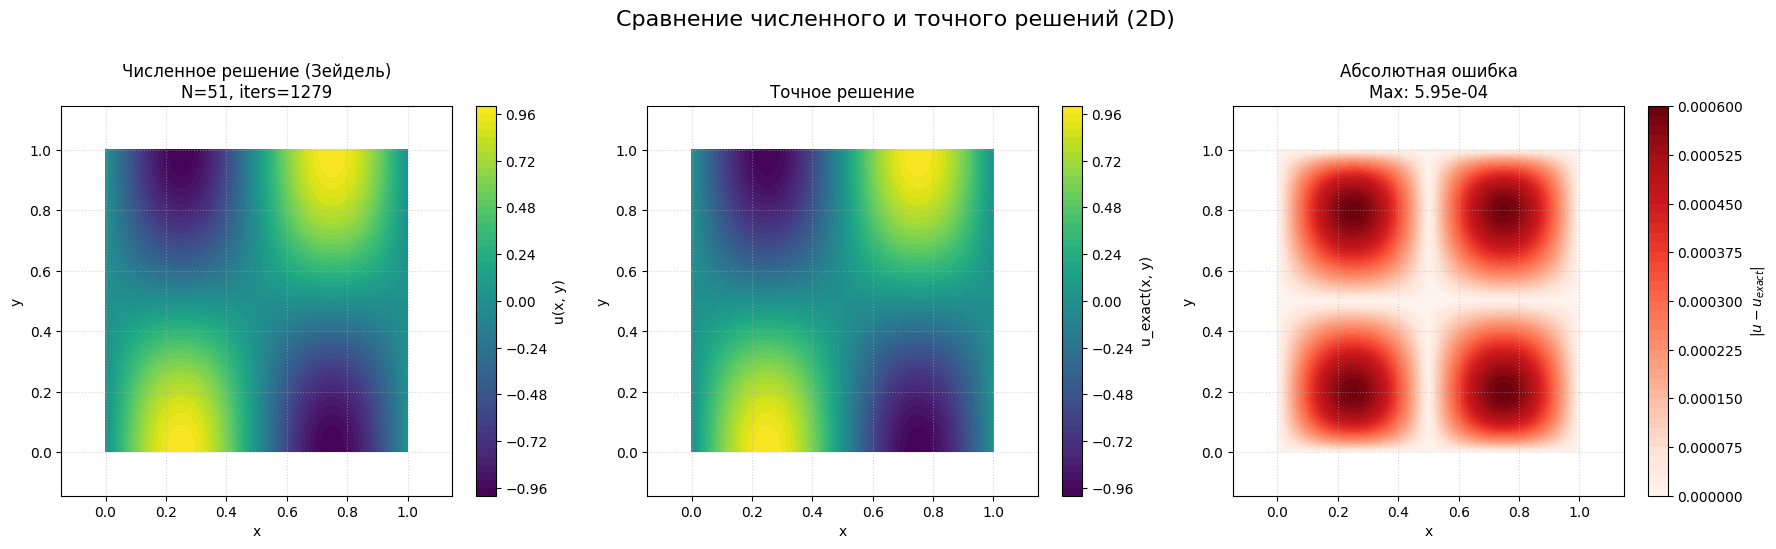

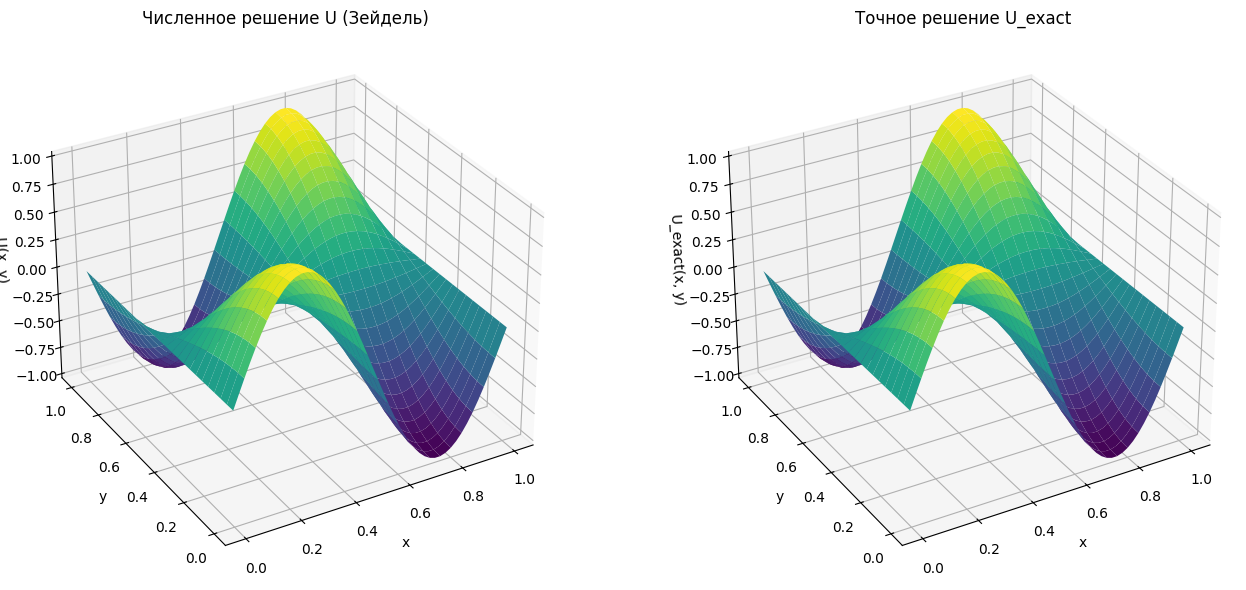

In [3]:
l = 1.0 # Размер области
N = 51  # Количество узлов (N-1 = 50 интервалов, h=1/50)

u_exact_func = lambda x, y: np.sin(2 * np.pi * x) * np.cos(np.pi * y)

f = lambda x, y: 5 * np.pi**2 * np.sin(2 * np.pi * x) * np.cos(np.pi * y)

# Граничные условия, соответствующие u_exact (для l=1)
phi1 = lambda x: u_exact_func(x, 0)   # y=0
phi2 = lambda x: u_exact_func(x, l)   # y=l
phi3 = lambda y: u_exact_func(0, y)   # x=0
phi4 = lambda y: u_exact_func(l, y)   # x=l

X, Y, U_numerical, F_grid, iters_gs = solve_poisson_gauss_seidel(
    l, N, f, phi1, phi2, phi3, phi4, tol=1e-6, max_iter=20000, verbose=True
)

U_exact = u_exact_func(X, Y)

# Вычисляем абсолютную ошибку
Error = np.abs(U_numerical - U_exact)
max_error = np.max(Error)

print(f"Параметры сетки: N = {N}, h = {l/(N-1):.4f}")
print(f"Количество итераций (Зейдель): {iters_gs}")
print(f"Максимальная абсолютная ошибка: {max_error:.3e}")

plt.figure(figsize=(18, 5.5))

# 1. Численное решение
plt.subplot(1, 3, 1)
contour_num = plt.contourf(X, Y, U_numerical, levels=50, cmap="viridis")
plt.colorbar(contour_num, label='u(x, y)')
plt.title(f"Численное решение (Зейдель)\nN={N}, iters={iters_gs}")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.5)

# 2. Точное решение
plt.subplot(1, 3, 2)
contour_exact = plt.contourf(X, Y, U_exact, levels=50, cmap="viridis")
plt.colorbar(contour_exact, label='u_exact(x, y)')
plt.title("Точное решение")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.5)

# 3. Абсолютная ошибка
plt.subplot(1, 3, 3)
contour_err = plt.contourf(X, Y, Error, levels=50, cmap="Reds")
plt.colorbar(contour_err, label='$|u - u_{exact}|$')
plt.title(f"Абсолютная ошибка\nMax: {max_error:.2e}")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Сравнение численного и точного решений (2D)", fontsize=16, y=1.02)
plt.show()

fig = plt.figure(figsize=(14, 6))

# Численное решение 3D
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, U_numerical, cmap='viridis', edgecolor='none', rstride=max(1, N//25), cstride=max(1, N//25)) # Адаптивное прореживание
ax1.set_title("Численное решение U (Зейдель)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("U(x, y)")
ax1.view_init(elev=30, azim=-120)

# Точное решение 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, U_exact, cmap='viridis', edgecolor='none', rstride=max(1, N//25), cstride=max(1, N//25)) # Адаптивное прореживание
ax2.set_title("Точное решение U_exact")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("U_exact(x, y)")
ax2.view_init(elev=30, azim=-120)

plt.tight_layout()
plt.show()